

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Cartpole**

This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the cartpole problem (see [Cartpole documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/)).


##Libraries

In [1]:
!pip install gymnasium[classic-control]

import gymnasium as gym
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.5 MB/s eta 0:00:00


## Hyperparameters

In [2]:
GAMMA = 0.99
MEMORY_SIZE = 100000
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.96
MAX_NUMBER_OF_EPISODES_FOR_TRAINING = 600
NUMBER_OF_EPISODES_FOR_TESTING = 30
GOAL_SCORE = 400
NUMBER_OF_EPISODES_FOR_TESTING_GOAL_SCORE = 30

## Class ReplayMemory

Memory of transitions for experience replay.

In [3]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]
        terminal_states = self.terminal_states[batch]
        return states, actions, rewards, states_next, terminal_states

## Class DQN

Reinforcement learning agent with a Deep Q-Network.

In [4]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create neural model
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)

        # Neural model
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Dense(24, input_shape=(number_of_observations,), \
                             activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(24, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(number_of_actions, activation="linear"))
        self.model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state, exploration_rate):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model(state).numpy()
            return np.argmax(q_values[0])

    def select_greedy_policy(self, state):
        # Generate an action for a given state using greedy policy
        state = np.reshape(state, [1, self.number_of_observations])
        q_values = self.model(state).numpy()
        return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model(states).numpy()
        q_next_states = self.model(next_states).numpy()

        for i in range(BATCH_SIZE):
             if (terminal_states[i]):
                  q_targets[i][actions[i]] = rewards[i]
             else:
                  q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])

        self.model.train_on_batch(states, q_targets)

    def add_score(self, score):
        # Add the obtained score to a list to be presented later
        self.scores.append(score)

    def delete_scores(self):
        # Delete the scores
        self.scores = []

    def average_score(self, number_of_episodes):
        # Compute average score of the last episodes
        index = len(agent.scores) - number_of_episodes
        return np.mean(self.scores[max(0,index):(len(agent.scores))])

    def display_scores_graphically(self):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")

## Environment Cartpole

<p><img height="200px" src="https://raw.githubusercontent.com/martin-molina/reinforcement_learning/main/images/cartpole_attributes.png" align="center" vspace="20px"</p>

State vector:
- state[0]: cart position
- state[1]: cart velocity
- state[2]: pole angle
- state[3]: pole angular velocity

Actions:
- 0 (push cart to the left)
- 1 (push cart to the right)

In [5]:
def create_environment():
    # Create simulated environment
    environment = gym.make("CartPole-v1")
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

## Program for training




Episode   1: score  14 (exploration rate: 1.000, average score:  14, transitions: 14)
Episode   2: score  10 (exploration rate: 0.960, average score:  12, transitions: 24)
Episode   3: score  40 (exploration rate: 0.922, average score:  21, transitions: 64)
Episode   4: score  11 (exploration rate: 0.885, average score:  19, transitions: 75)
Episode   5: score  11 (exploration rate: 0.849, average score:  17, transitions: 86)
Episode   6: score  21 (exploration rate: 0.815, average score:  18, transitions: 107)
Episode   7: score  11 (exploration rate: 0.783, average score:  17, transitions: 118)
Episode   8: score  14 (exploration rate: 0.751, average score:  16, transitions: 132)
Episode   9: score  12 (exploration rate: 0.721, average score:  16, transitions: 144)
Episode  10: score  18 (exploration rate: 0.693, average score:  16, transitions: 162)
Episode  11: score   9 (exploration rate: 0.665, average score:  16, transitions: 171)
Episode  12: score  15 (exploration rate: 0.638,

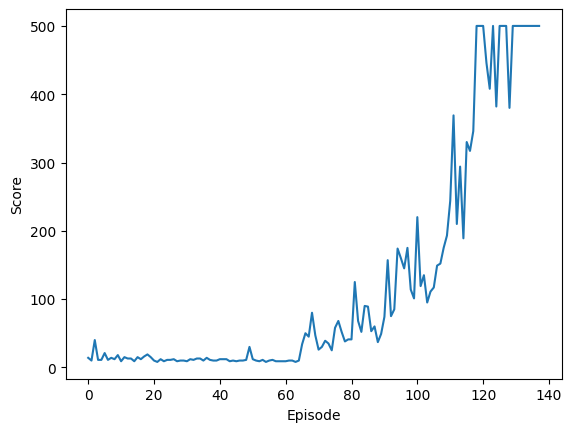

In [6]:
environment, number_of_observations, number_of_actions = create_environment()
agent = DQN(number_of_observations, number_of_actions)
episode = 0
start_time = time.perf_counter()
total_steps = 1
exploration_rate = EXPLORATION_MAX
goal_reached = False
while (episode < MAX_NUMBER_OF_EPISODES_FOR_TRAINING) and not(goal_reached):
    episode += 1
    score = 0
    state, info = environment.reset()
    end_episode = False
    while not(end_episode):
        # Select an action for the current state
        action = agent.select(state, exploration_rate)

        # Execute the action on the environment
        state_next, reward, terminal_state, truncated, info = environment.step(action)

        # Store in memory the transition (s,a,r,s')
        agent.remember(state, action, reward, state_next, terminal_state)

        score += reward

        # Learn using a batch of experience stored in memory
        agent.learn()

        # Detect end of episode
        if terminal_state or truncated:
            end_episode = True
            agent.add_score(score)
            average_score = agent.average_score(NUMBER_OF_EPISODES_FOR_TESTING_GOAL_SCORE)
            if average_score >= GOAL_SCORE: goal_reached = True
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} ".format(math.trunc(score)), end = '')
            print("(exploration rate: %.3f, " % exploration_rate, end = '')
            print("average score: {0:>3}, ".format(round(average_score)), end = '')
            print("transitions: " + str(agent.memory.current_size) + ")")
        else:
            state = state_next
            total_steps += 1

    # Decrease exploration rate
    exploration_rate *= EXPLORATION_DECAY
    exploration_rate = max(EXPLORATION_MIN, exploration_rate)

print("Time for training:", round((time.perf_counter() - start_time)/60), "minutes")
print("Score (average last episodes):", round(average_score))
print("Score (max):", round(max(agent.scores)))

agent.display_scores_graphically()


## Program for testing



In [7]:
agent.delete_scores()
episode = 0
start_time = time.perf_counter()
while (episode < NUMBER_OF_EPISODES_FOR_TESTING):
    episode += 1
    score = 0
    state, info = environment.reset()
    end_episode = False
    while not(end_episode):
        # Select an action for the current state
        action = agent.select_greedy_policy(state)

        # Execute the action in the environment
        state_next, reward, terminal_state, truncated, info = environment.step(action)

        score += reward

        # Detect end of episode and print
        if terminal_state or truncated:
            agent.add_score(score)
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} \n".format(round(score)), end = '')
            end_episode = True
        else:
            state = state_next

print("Time for testing:", round((time.perf_counter() - start_time)/60), "minutes")
print("Score (average):", round(np.mean(agent.scores)))
print("Score (max):", round(max(agent.scores)))

Episode   1: score 500 
Episode   2: score 500 
Episode   3: score 500 
Episode   4: score 500 
Episode   5: score 500 
Episode   6: score 500 
Episode   7: score 500 
Episode   8: score 500 
Episode   9: score 500 
Episode  10: score 500 
Episode  11: score 500 
Episode  12: score 500 
Episode  13: score 500 
Episode  14: score 500 
Episode  15: score 500 
Episode  16: score 500 
Episode  17: score 500 
Episode  18: score 500 
Episode  19: score 500 
Episode  20: score 500 
Episode  21: score 500 
Episode  22: score 500 
Episode  23: score 500 
Episode  24: score 500 
Episode  25: score 500 
Episode  26: score 500 
Episode  27: score 500 
Episode  28: score 500 
Episode  29: score 500 
Episode  30: score 500 
Time for testing: 1 minutes
Score (average): 500
Score (max): 500
